In [1]:
import os
import sys

#sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import importlib

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [3]:
dataset.shape

(2860, 18)

In [31]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
n_samples = 1300
batch_size = 260
n_components = 3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)

In [10]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 3
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction

OGMM.generate_list()

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\Online_GMM.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


[[tensor(3.7446e-06),
  tensor(23.5341),
  tensor([ 0.2566, -0.0072,  0.0018]),
  tensor([[ 8.7732e-04, -8.1179e-06, -4.3610e-05],
          [-8.1179e-06,  1.6886e-04,  1.0428e-04],
          [-4.3610e-05,  1.0428e-04,  4.0313e-04]])],
 [tensor(8.4565e-11),
  tensor(18.0840),
  tensor([-0.3460, -0.0053,  0.0118]),
  tensor([[ 0.0042,  0.0004, -0.0010],
          [ 0.0004,  0.0013,  0.0002],
          [-0.0010,  0.0002,  0.0014]])],
 [tensor(9.6604e-08),
  tensor(6.9066),
  tensor([-0.5394,  0.4402,  0.0554]),
  tensor([[ 0.0214,  0.0068, -0.0184],
          [ 0.0068,  0.0124,  0.0016],
          [-0.0184,  0.0016,  0.0283]])],
 [tensor(0.0001),
  tensor(11.3709),
  tensor([0.1283, 0.5368, 0.0433]),
  tensor([[0.0109, 0.0077, 0.0068],
          [0.0077, 0.0169, 0.0182],
          [0.0068, 0.0182, 0.0217]])],
 [tensor(6.7955e-07),
  tensor(3.4565),
  tensor([ 0.0818, -0.4050,  0.5018]),
  tensor([[ 0.0039, -0.0060,  0.0122],
          [-0.0060,  0.0280, -0.0521],
          [ 0.0122, -0.0

Test to determine the best K_max

In [11]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood(X_test_target_t, dimension_reduction=True))

Couldn't find program: 'false'


## Dictionary learning seperated between sources and target

In [12]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [13]:
criterion = JointWassersteinDistance()

In [14]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [15]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


It 0/40, Loss: 108.09393615722657


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


It 1/40, Loss: 47.26533584594726


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


It 2/40, Loss: 20.928940200805663


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


It 3/40, Loss: 9.391120624542236


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


It 4/40, Loss: 4.793044662475586


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


It 5/40, Loss: 2.85367374420166


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


It 6/40, Loss: 1.9054070711135864


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


It 7/40, Loss: 1.3791471481323243


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


It 8/40, Loss: 1.0758727073669432


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


It 9/40, Loss: 0.8465428352355957


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


It 10/40, Loss: 0.7338719129562377


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


It 11/40, Loss: 0.6412883996963501


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


It 12/40, Loss: 0.5886342406272889


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


It 13/40, Loss: 0.5585440516471863


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


It 14/40, Loss: 0.5287287712097167


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


It 15/40, Loss: 0.5071732759475709


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


It 16/40, Loss: 0.4943889379501343


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


It 17/40, Loss: 0.4896742641925812


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


It 18/40, Loss: 0.47025383114814756


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


It 19/40, Loss: 0.4510028064250946


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


It 20/40, Loss: 0.4474387228488922


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


It 21/40, Loss: 0.41635237932205205


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


It 22/40, Loss: 0.38956190347671504


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


It 23/40, Loss: 0.3542194306850433


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


It 24/40, Loss: 0.3043831169605255


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


It 25/40, Loss: 0.26599013805389404


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


It 26/40, Loss: 0.24917243421077728


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


It 27/40, Loss: 0.22701725065708162


100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


It 28/40, Loss: 0.22190642952919007


100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


It 29/40, Loss: 0.21675021946430206


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


It 30/40, Loss: 0.20326912701129912


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


It 31/40, Loss: 0.2187014579772949


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


It 32/40, Loss: 0.2058379918336868


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


It 33/40, Loss: 0.20249702036380768


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


It 34/40, Loss: 0.2016796410083771


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


It 35/40, Loss: 0.20052754878997803


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


It 36/40, Loss: 0.1966956049203873


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


It 37/40, Loss: 0.18851777017116547


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


It 38/40, Loss: 0.1995221734046936


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]

It 39/40, Loss: 0.1893874019384384


In [16]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [17]:
names_sources = [f'domain {i}' for i in range(6)]

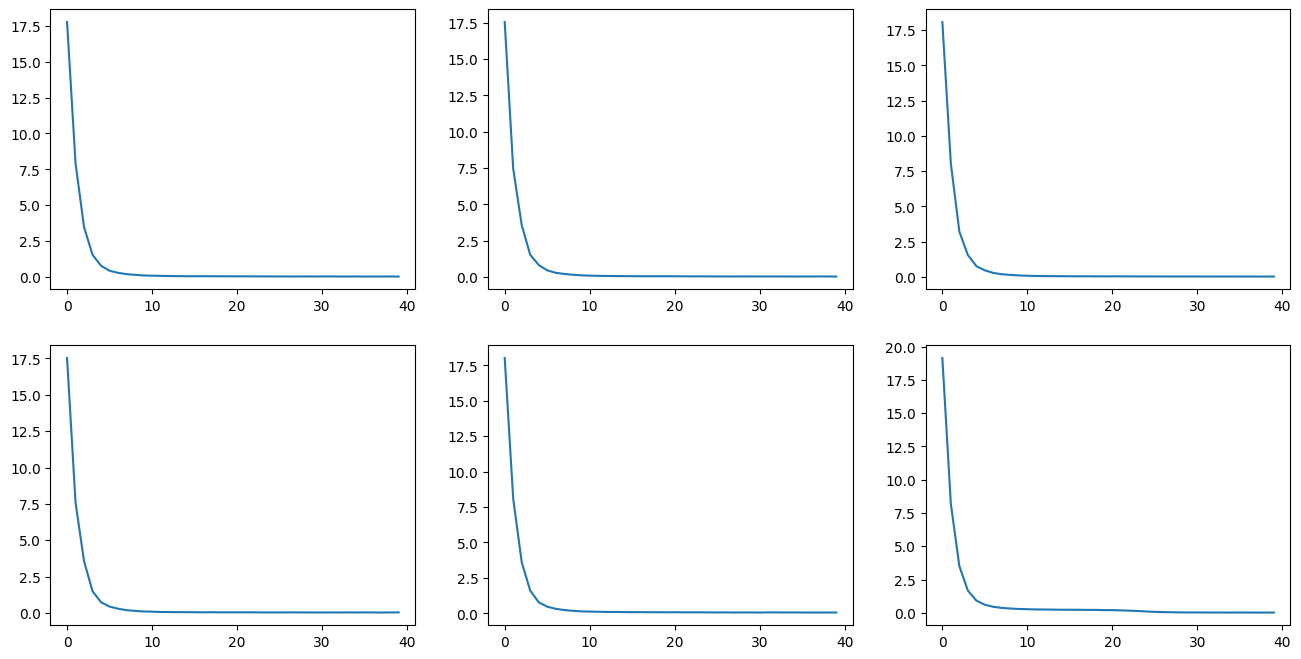

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

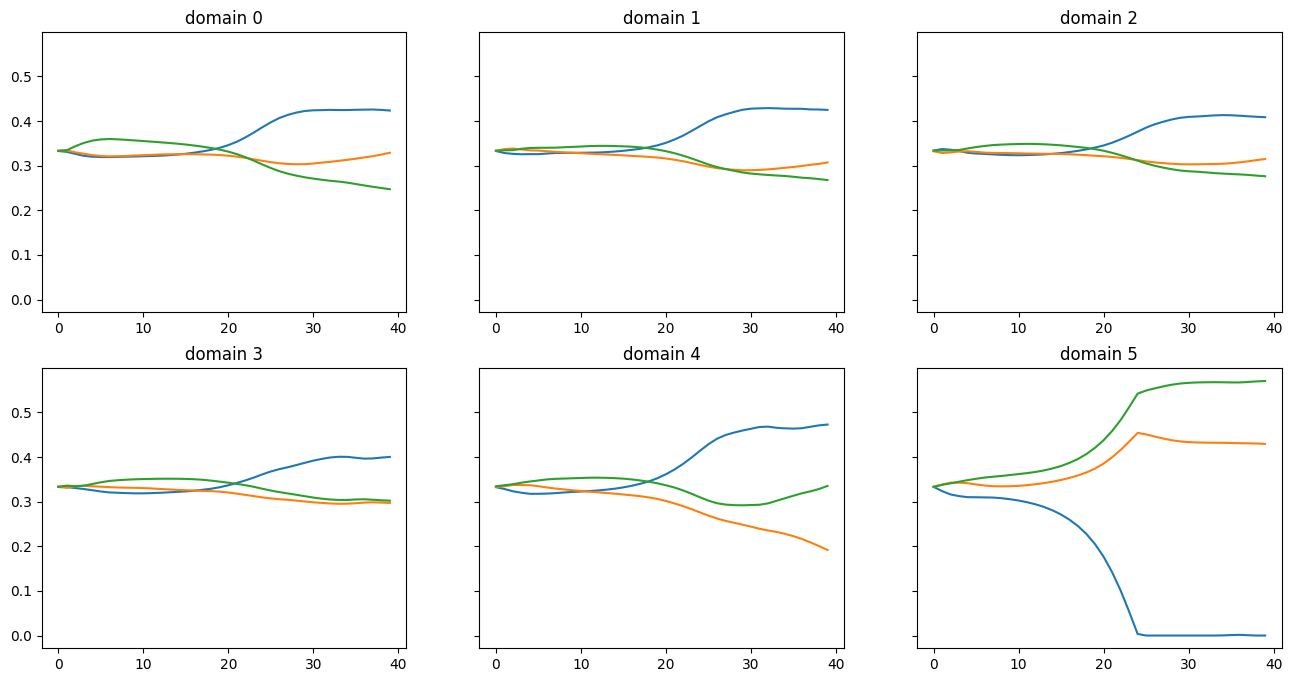

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [20]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [75]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))


In [76]:
range_data

0.467191409893893

In [57]:
X[np.where(d!=6)[0], :].shape

(2600, 14)

In [68]:
dictionary_target.XP[0].shape

torch.Size([1300, 14])

In [73]:
torch.min(torch.concat(list(dictionary_target.XP), axis = 0), axis=0).values

tensor([-0.1507, -0.0773, -0.0971, -0.0645, -0.4830, -0.3086, -0.5421, -0.2793,
        -0.4372, -0.3798, -0.1427, -0.1148, -0.3224, -0.2852],
       grad_fn=<MinBackward0>)

In [77]:
torch.mean(torch.max(torch.concat(list(dictionary_target.XP), axis = 0), axis=0).values - torch.min(torch.concat(list(dictionary_target.XP), axis = 0), axis=0).values).item()

1.0000312328338623

In [21]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


It 0/40, Loss: 0.24859684109687807


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


It 1/40, Loss: 0.2510934561491013


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


It 2/40, Loss: 0.24885609745979312


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


It 3/40, Loss: 0.2439216136932373


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


It 4/40, Loss: 0.2462320178747177


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


It 5/40, Loss: 0.24587343633174896


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


It 6/40, Loss: 0.24340365827083585


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


It 7/40, Loss: 0.23945493996143338


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


It 8/40, Loss: 0.24159168303012846


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


It 9/40, Loss: 0.24405979812145234


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


It 10/40, Loss: 0.24348227679729462


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


It 11/40, Loss: 0.2504683881998062


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


It 12/40, Loss: 0.25061239004135133


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


It 13/40, Loss: 0.2508259117603302


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


It 14/40, Loss: 0.24654462933540344


100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


It 15/40, Loss: 0.24593704640865321


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


It 16/40, Loss: 0.253020703792572


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


It 17/40, Loss: 0.2476331740617752


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


It 18/40, Loss: 0.2449814796447754


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


It 19/40, Loss: 0.24356304109096527


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


It 20/40, Loss: 0.24701330959796902


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


It 21/40, Loss: 0.24526384174823762


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


It 22/40, Loss: 0.24838114678859713


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


It 23/40, Loss: 0.24450648128986358


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


It 24/40, Loss: 0.2507917404174805


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


It 25/40, Loss: 0.24667237997055053


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


It 26/40, Loss: 0.24947299361228942


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


It 27/40, Loss: 0.2443636178970337


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


It 28/40, Loss: 0.24551815092563628


100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


It 29/40, Loss: 0.25107693374156953


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


It 30/40, Loss: 0.251120924949646


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


It 31/40, Loss: 0.24914516508579254


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


It 32/40, Loss: 0.24199730753898624


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


It 33/40, Loss: 0.24507944583892824


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


It 34/40, Loss: 0.2451050877571106


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


It 35/40, Loss: 0.24847510159015657


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


It 36/40, Loss: 0.24579229950904846


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


It 37/40, Loss: 0.2518409490585327


100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


It 38/40, Loss: 0.24850680530071256


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

It 39/40, Loss: 0.2476516902446747


In [22]:
target_name = 'Domain 7'

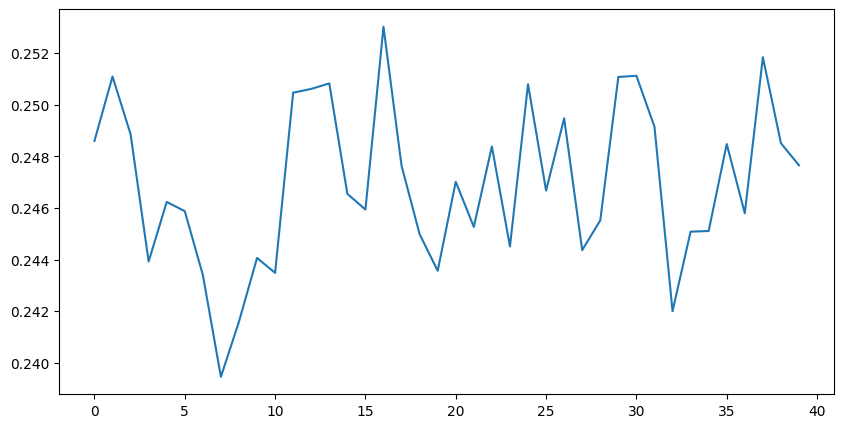

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

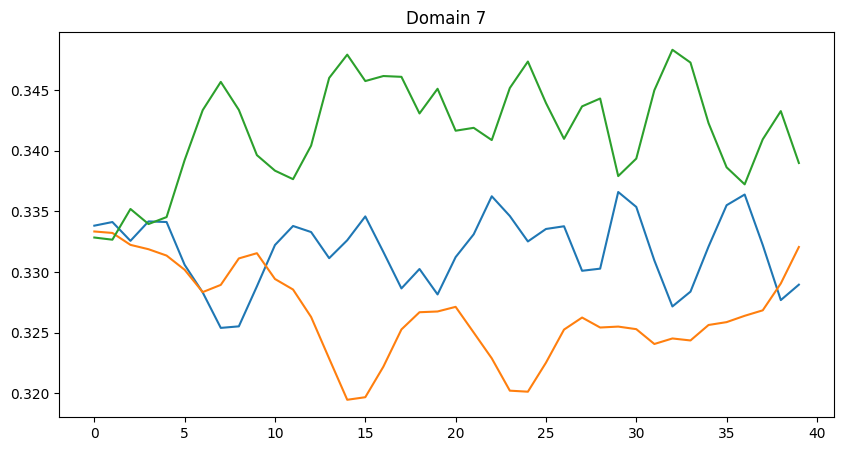

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, 0, :])
ax.set_title(target_name)

In [25]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3290, 0.3321, 0.3390])


In [26]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [27]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


DaDiL-E

In [28]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.32899999618530273 got 0.24615384615384617
Atom 1 w/ weight 0.3319999873638153 got 0.5153846153846153
Atom 2 w/ weight 0.33899998664855957 got 0.5769230769230769
0.5576923076923077


DaDiL-R

In [29]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5884615384615385


## Classic Dictionary Learning

In [15]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [21]:
criterion = JointWassersteinDistance()

In [17]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [ ]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

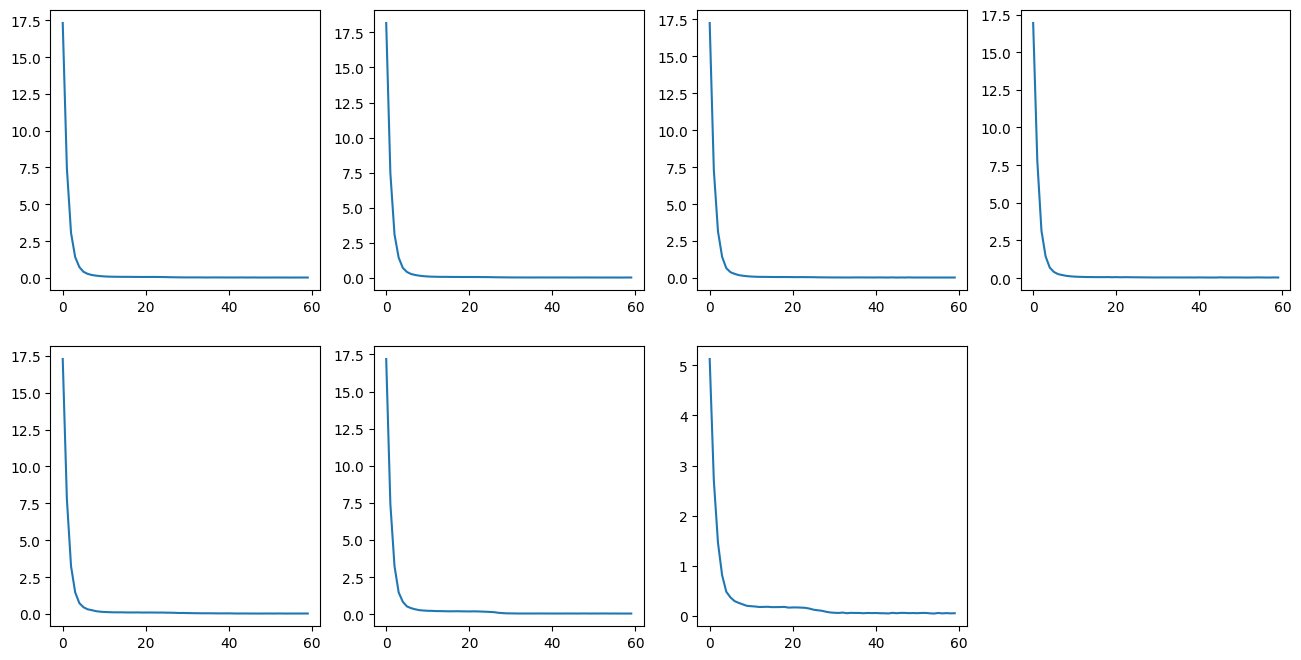

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0673781655728817, 0.7154823370277882)

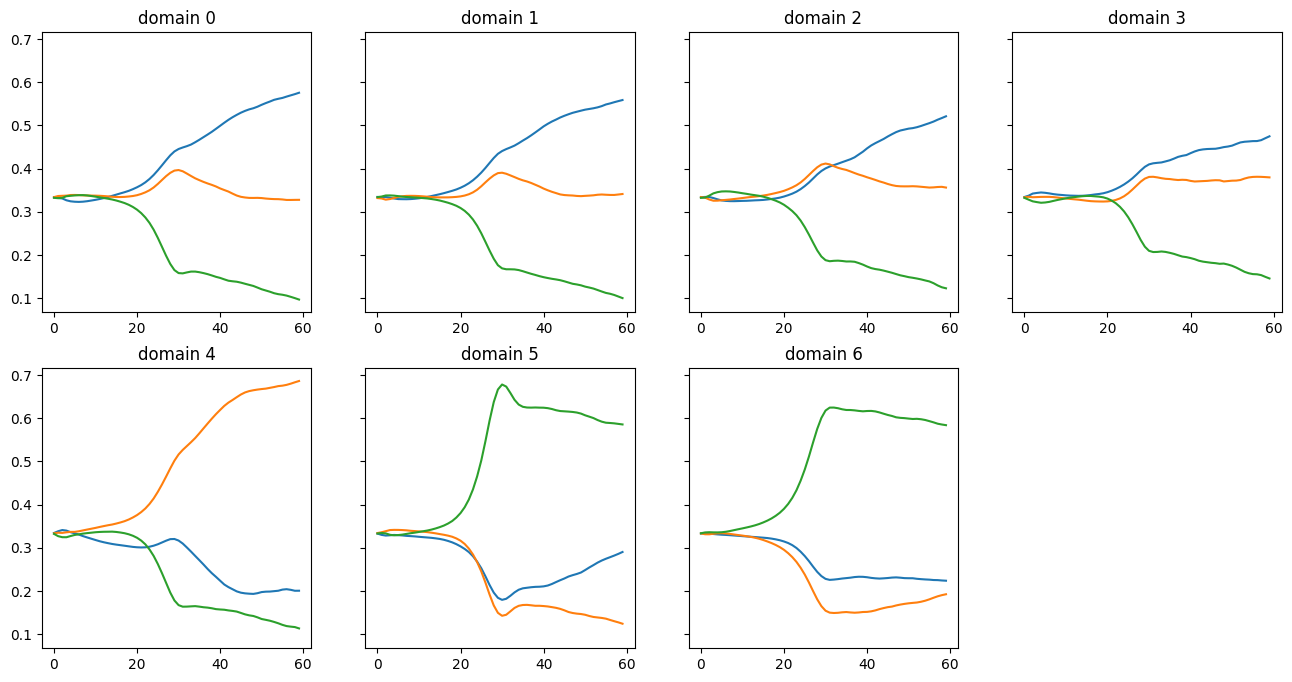

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [ ]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2238, 0.1924, 0.5838])


In [ ]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


In [ ]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.328000009059906 got 0.5615384615384615
Atom 1 w/ weight 0.33899998664855957 got 0.33076923076923076
Atom 2 w/ weight 0.33399999141693115 got 0.6692307692307692
0.6076923076923076


In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5923076923076923
